In [1]:
!nvidia-smi

Tue Jan 18 10:25:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     Off  | 00000000:37:00.0 Off |                  Off |
| 33%   31C    P8    11W / 260W |      5MiB / 48601MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     Off  | 00000000:86:00.0 Off |                  Off |
| 33%   

In [2]:
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader

def join_text(list_text):
    return ' '.join(list_text)

class ContrastDataset(Dataset):
    def __init__(self, text_data, steps):
        self.text_data = text_data
        self.authors = text_data.author.unique().tolist()
        self.text_data = self.text_data.set_index(['author', 'chunk_id'])
        self.steps = steps

    def __len__(self):
        return self.steps
    
    def __getitem__(self, i):
        n_auth = len(self.authors)
        auth = self.authors[i%n_auth]
        anchor, replica = self.text_data.loc[auth].sample(2).chunk.tolist()
        
        return anchor, replica
    
class TextCollator:
    def __init__(self, tokenizer, max_len=196):
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __call__(self, texts):
        anchors, replicas = list(zip(*texts))
        config = dict(padding='max_length',
                      return_tensors='pt',
                      truncation=True,
                      max_length=self.max_len,)

        encoded_anchors = self.tokenizer(list(anchors), **config)
        encoded_replicas = self.tokenizer(list(replicas), **config)

        return encoded_anchors.input_ids, encoded_anchors.attention_mask, encoded_replicas.input_ids, encoded_replicas.attention_mask
    
    
def build_dataset(dataframe, tokenizer, steps, max_len=128, shuffle=False, batch_size=16, num_workers=4, prefetch_factor=4, samples_per_line=1):
    data = ContrastDataset(dataframe, steps)
    
    return DataLoader(data,
                      batch_size=batch_size,
                      shuffle=shuffle,
                      num_workers=num_workers,
                      prefetch_factor=prefetch_factor,
                      collate_fn=TextCollator(tokenizer, max_len=max_len),
                     )

In [2]:
import pandas as pd

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('roberta-large')

train, test = pd.read_csv('gutenberg_train.csv').sample(frac=1), pd.read_csv('gutenberg_test.csv')

train_data = build_dataset(train, tokenizer, steps=len(train), batch_size=512, max_len=512)
test_data = build_dataset(test, tokenizer, steps=5000, batch_size=100, num_workers=2, prefetch_factor=2, max_len=512)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


NameError: name 'build_dataset' is not defined

In [4]:
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import pytorch_lightning as pl 
import torch.nn.functional as F

class DynamicLSTM(pl.LightningModule):
    def __init__(self, input_size, hidden_size=100,
                 num_layers=1, dropout=0., bidirectional=False):
        super(DynamicLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = torch.nn.LSTM(
            input_size, self.hidden_size, num_layers, bias=True,
            batch_first=True, dropout=dropout, bidirectional=bidirectional)

    def forward(self, x, attention_mask=None):
        
        if attention_mask is None:
            attention_mask = torch.ones(x.shape[:-1], device=self.device)

        seq_lens = attention_mask.sum(-1)
        batch_size = attention_mask.shape[0]
        seq_len = attention_mask.shape[1]
        
        
        # sort input by descending length
        _, idx_sort = torch.sort(seq_lens, dim=0, descending=True)
        _, idx_unsort = torch.sort(idx_sort, dim=0)
        x_sort = torch.index_select(x, dim=0, index=idx_sort)
        seq_lens_sort = torch.index_select(seq_lens, dim=0, index=idx_sort)

        # pack input
        x_packed = pack_padded_sequence(
            x_sort, seq_lens_sort.cpu(), batch_first=True)

        # pass through rnn
        y_packed, _ = self.lstm(x_packed)

        # unpack output
        y_sort, length = pad_packed_sequence(y_packed, batch_first=True)

        # unsort output to original order
        y = torch.index_select(y_sort, dim=0, index=idx_unsort)
        
        batch_indices = torch.arange(0, batch_size, device=self.device)
        seq_indices = seq_lens - 1
        
        y_split = y.view(batch_size, seq_len, 2, self.hidden_size)
        
        output = torch.cat([y_split[batch_indices, seq_indices, 0], y_split[batch_indices, 0, 1]], dim=-1)

        return output

class ContrastivePretrain(pl.LightningModule):
    def __init__(self, transformer,
                 learning_rate=5e-5,
                 weight_decay=.01,
                 num_warmup_steps=1000,
                 num_training_steps=10000,
                ):
        super().__init__()
        
        # Save hyperparameters for training
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.num_warmup_steps = num_warmup_steps
        self.num_training_steps = num_training_steps

        self.save_hyperparameters()
        
        self.transformer = transformer
        embed_size = transformer.config.hidden_size//2
        self.pooler = DynamicLSTM(transformer.config.hidden_size,
                                  embed_size,
                                  dropout=.1,
                                  bidirectional=True)
        self.temperature = torch.nn.Parameter(torch.Tensor([.07]))
        
        self.switch_finetune(False)
        #self.norm = torch.nn.LayerNorm(embed_size)
    
    def switch_finetune(self, switch=True):
        for param in self.transformer.parameters():
            param.requires_grad = switch
    
    def forward(self, input_ids, attention_mask=None):        
        embeds = self.transformer(input_ids, attention_mask).last_hidden_state
        
        return F.normalize(self.pooler(embeds, attention_mask))

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = get_linear_schedule_with_warmup(
            optimizer= optimizer,
            num_warmup_steps=self.num_warmup_steps,
            num_training_steps=self.num_training_steps,
        )
        
        lr_scheduler_config = {
            "scheduler": scheduler,
            "interval": 'step',
            "frequency": 1,
            "monitor": "val_loss",
            "strict": True,
            "name": 'linear_schedule_with_warmup',
        }
        
        return {'optimizer': optimizer,
                'lr_scheduler': lr_scheduler_config,
               }        
    
    def infonce_loss(self, a, b):
        batch_size = a.shape[0]
        logits = (a @ b.T) * torch.exp(self.temperature).clamp(max=100)
        labels = torch.arange(0, batch_size, device=self.device)
    
        loss = (F.cross_entropy(logits.T, labels).mean() + F.cross_entropy(logits, labels).mean()) / 2
    
        with torch.no_grad():
            preds = F.softmax(logits, dim=1).argmax(-1)
            preds_t = F.softmax(logits.T, dim=1).argmax(-1)

            accuracy = (torch.sum(preds == labels) + torch.sum(preds_t == labels)) / (batch_size * 2)

        return loss, accuracy
        
    def eval_batch(self, batch, mode='train'):
        anchors_input_ids, anchors_attention_mask, replicas_input_ids, replicas_attention_mask = batch
        
        anchor_embeds = self(anchors_input_ids, anchors_attention_mask)
        replicas_embeds = self(replicas_input_ids, replicas_attention_mask)

        loss, acc = self.infonce_loss(anchor_embeds, replicas_embeds)

        self.log(f'{mode}/infonce_loss', loss)
        self.log(f'{mode}/infonce_acc', acc)

        return loss

    def training_step(self, train_batch, batch_idx):
        return self.eval_batch(train_batch)

    def validation_step(self, val_batch, batch_idx):
        return self.eval_batch(val_batch, mode='valid')
    
    def predict_step(self, pred_batch, batch_idx):
        anchors, _, _ = pred_batch
        
        return self(anchors.input_ids, anchors.attention_mask)

In [ ]:
from transformers import AutoModel

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning import Trainer

from datetime import datetime

import wandb

date_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

print("date and time:",date_time)

MIN_TRAIN_STEPS = 10000
LR = 5e-3
DECAY = .01
WARMUP_STEPS = 1000

SAVE_NAME = f'{date_time}_NCEPretrain_frozen_lstm'

wandb.login()

wandb_logger = WandbLogger(name=SAVE_NAME, project="author_profiling")

checkpoint_callback = ModelCheckpoint('model',
                                      filename=SAVE_NAME,
                                      monitor=None,
                                      every_n_val_epochs=1,
                                     )
    
#early_stop_callback = EarlyStopping(monitor="valid/loss", min_delta=1e-8, patience=10, verbose=True, mode="min")
lr_monitor = LearningRateMonitor('step')

trainer = Trainer(devices=[1],
                  accumulate_grad_batches=1,
                  max_steps=MIN_TRAIN_STEPS,
                  accelerator='gpu',
                  log_every_n_steps=1,
                  flush_logs_every_n_steps=500,
                  logger=wandb_logger,
                  strategy='dp',
                  precision=16,
                  val_check_interval=500,
                  callbacks=[checkpoint_callback, lr_monitor],
                 )

base_transformer = AutoModel.from_pretrained('roberta-large')

train_model = ContrastivePretrain(base_transformer,
                                  learning_rate=LR,
                                  weight_decay=DECAY,
                                  num_warmup_steps=WARMUP_STEPS,
                                  num_training_steps=MIN_TRAIN_STEPS)

trainer.fit(train_model, train_data, test_data)
wandb.finish()

date and time: 2022-01-18_10-25-50


wandb: Currently logged in as: jahuerta92 (use `wandb login --relogin` to force relogin)
/home/jhuertas/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:237: LightningDeprecationWarning: `ModelCheckpoint(every_n_val_epochs)` is deprecated in v1.4 and will be removed in v1.6. Please use `every_n_epochs` instead.
  rank_zero_deprecation(
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/jhuertas/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:59: LightningDeprecationWarning: Setting `Trainer(flush_logs_every_n_steps=500)` is deprecated in v1.5 and will be removed in v1.7. Please configure flushing in the logger instead.
  rank_zero_deprecation(
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.laye


  | Name        | Type         | Params
---------------------------------------------
0 | transformer | RobertaModel | 355 M 
1 | pooler      | DynamicLSTM  | 6.3 M 
---------------------------------------------
6.3 M     Trainable params
355 M     Non-trainable params
361 M     Total params
723.319   Total estimated model params size (MB)
/home/jhuertas/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/jhuertas/work/notebooks/author_profiling/model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/home/jhuertas/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [5]:
def predict(model, data, batch=128, dev=1):
    embeds = []
    data = data.groupby('user_id').apply(lambda x: '\n'.join(x.text.tolist())).tolist()
    encoded = tokenizer(data, return_tensors='pt', max_length=512, truncation=True)
    
    with torch.no_grad():
        for i in range(0, len(data), batch):
                embeds.append(model(encoded.input_ids[i:i+batch].cuda(dev), encoded.attention_mask[i:i+batch].cuda(dev)))

        return torch.cat(embeds, dim=0)
    

In [6]:
import torch
torch.cuda.empty_cache()

In [7]:
train_model = ContrastivePretrain.load_from_checkpoint('model/2022-01-17_22-05-37_NCEPretrain_frozen_lstm.ckpt').cuda(1)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [8]:
import pandas as pd
train, test = pd.read_csv('train_data.csv'), pd.read_csv('test_data.csv')
test = test[test.lang.isin({'en'})]
#embeddings_train = predict(train_model, train, batch=128, dev=1).cpu().numpy()
embeddings_test = predict(train_model, test, batch=128, dev=1).cpu().numpy()

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_df(df):
    %matplotlib inline

    plt.figure(figsize=(15,12))

    sns.set_style("whitegrid")

    ax = sns.scatterplot(x='umap_0', # Horizontal axis
               y='umap_1', # Vertical axis
               data=df, # Data source
               hue='label',
               palette="Spectral") # size and dimension

    '''
    ax = sns.scatterplot(x="umap_0",
                         y="umap_1",
                         data=hoaxes,
                         hue="label_re",
                         marker="+",
                         s=2000,
                         palette="Spectral",
                         legend=False)
    '''

    #plt.title('NLI')
    # Set x-axis label
    plt.xlabel('Component 1')
    # Set y-axis label
    plt.ylabel('Component 2')
    legend = plt.legend(fancybox = True)
    legend.set_title('Hoax')

    frame = legend.get_frame() #sets up for color, edge, and transparency
    frame.set_facecolor('#b4aeae') #color of legend
    frame.set_edgecolor('black') #edge color of legend
    frame.set_alpha(1) #deals with transparency
    
    plt.show()

In [10]:
import umap
from sklearn.preprocessing import StandardScaler

def make_plot(embeddings_train, n_neighbors, min_dist):
    scaler = StandardScaler()
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, metric='cosine')
    scaled_embs = scaler.fit_transform(embeddings_train)
    reduced_embs = reducer.fit_transform(scaled_embs)
    
    df = pd.DataFrame({'umap_0': reduced_embs[:,0],
                   'umap_1': reduced_embs[:,1],
                   'label': test.groupby('user_id').apply(lambda x: x.label.tolist()[0]),
                  })
    print(f'n_neighbors:{n_neighbors}, min_dist:{min_dist}')
    plot_df(df)
    
    return df

n_neighbors:2, min_dist:0.01


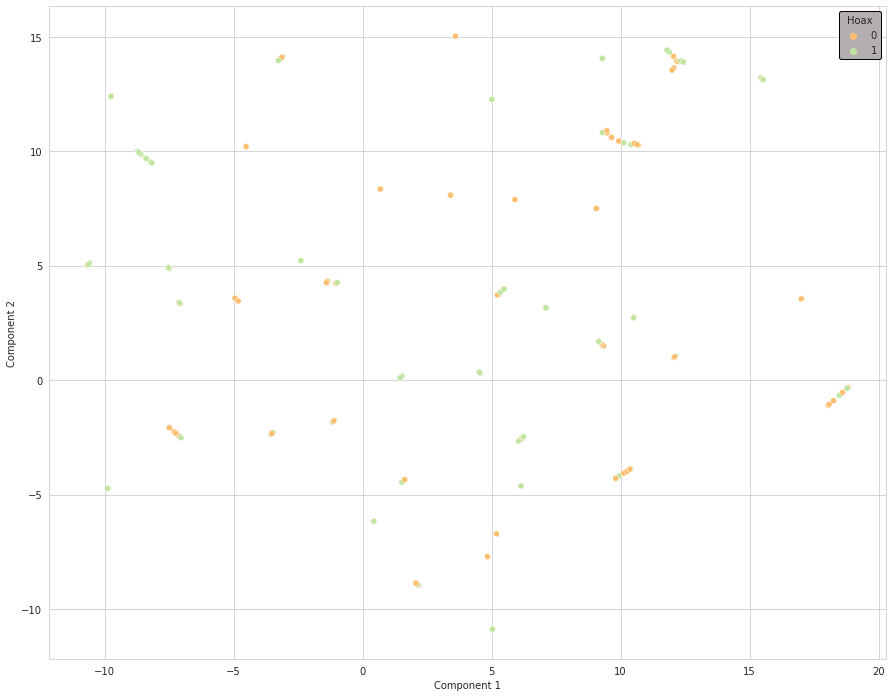

n_neighbors:2, min_dist:0.1


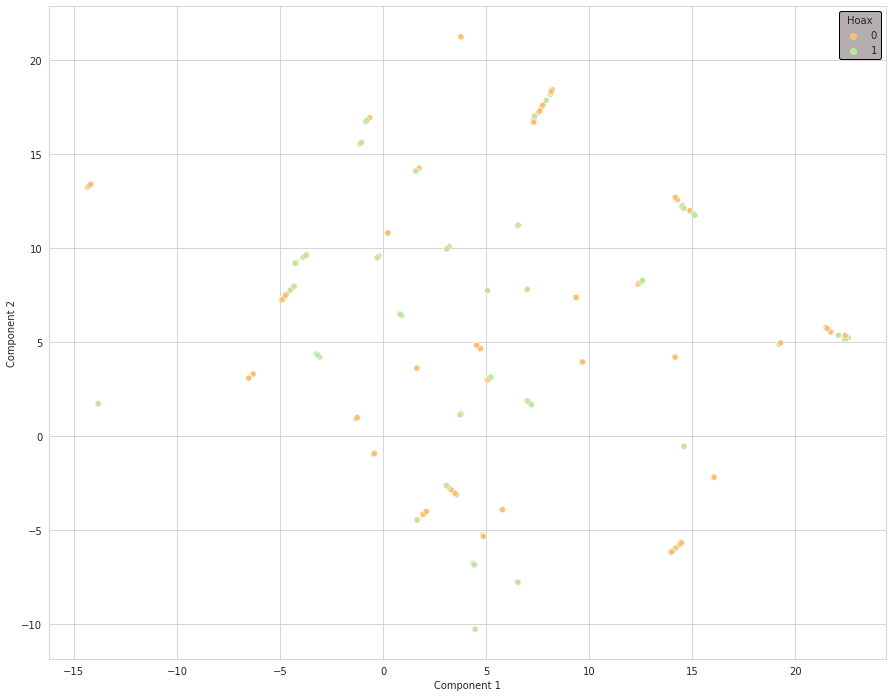

/home/jhuertas/.local/lib/python3.8/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


n_neighbors:2, min_dist:0.25


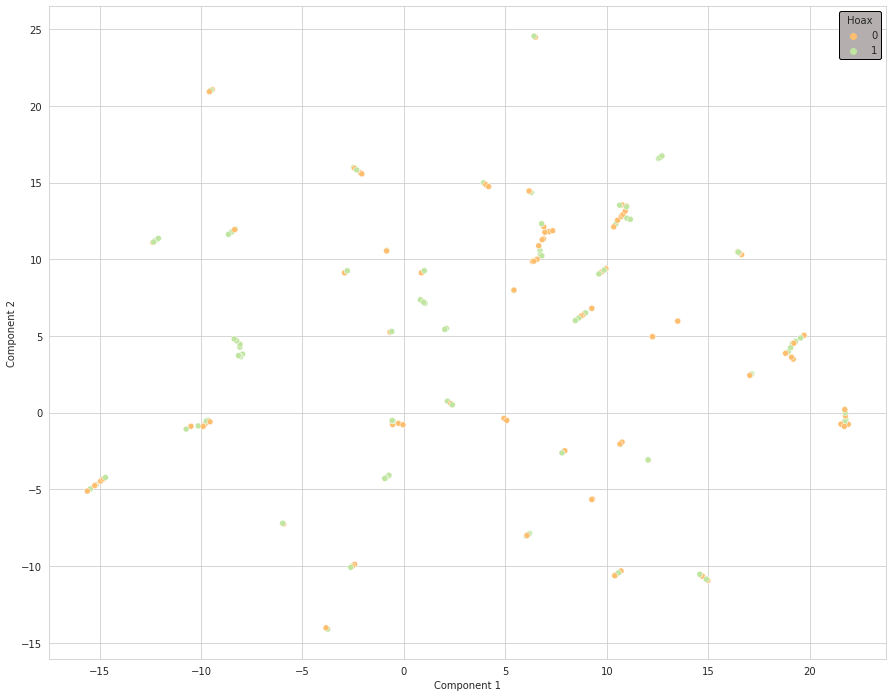

n_neighbors:2, min_dist:0.5


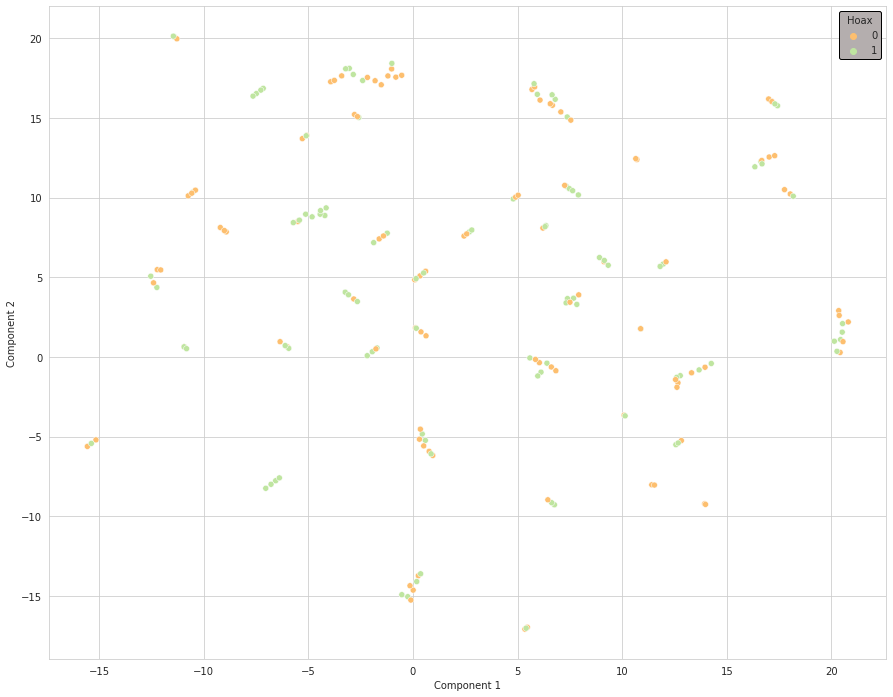

n_neighbors:2, min_dist:0.75


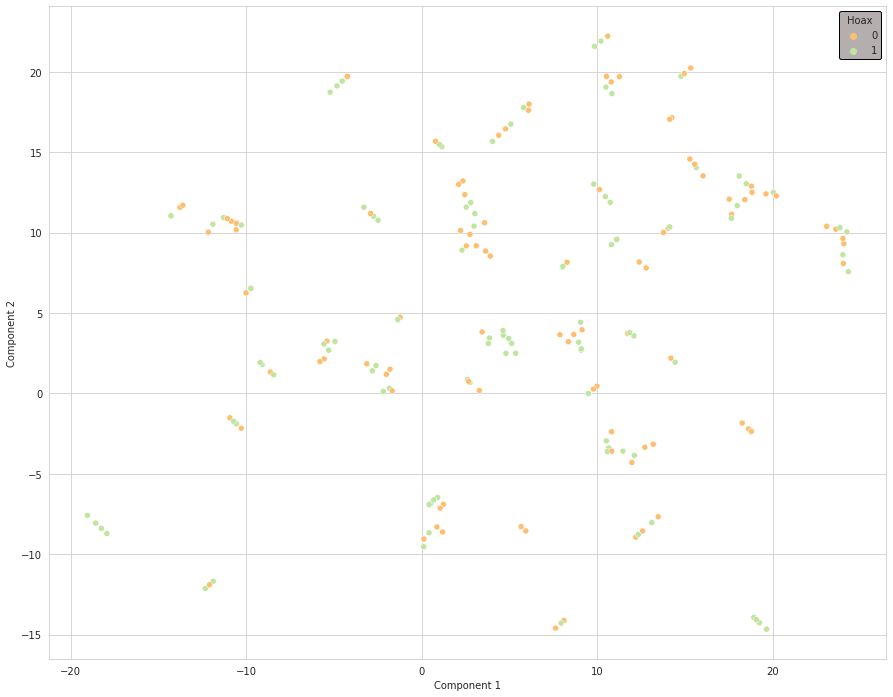

n_neighbors:2, min_dist:0.9


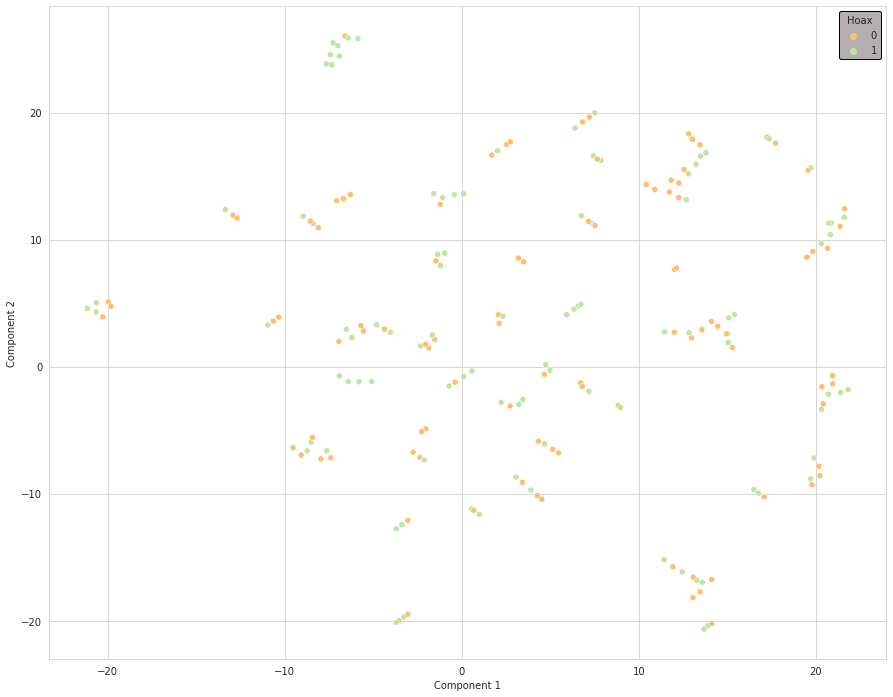

n_neighbors:2, min_dist:0.99


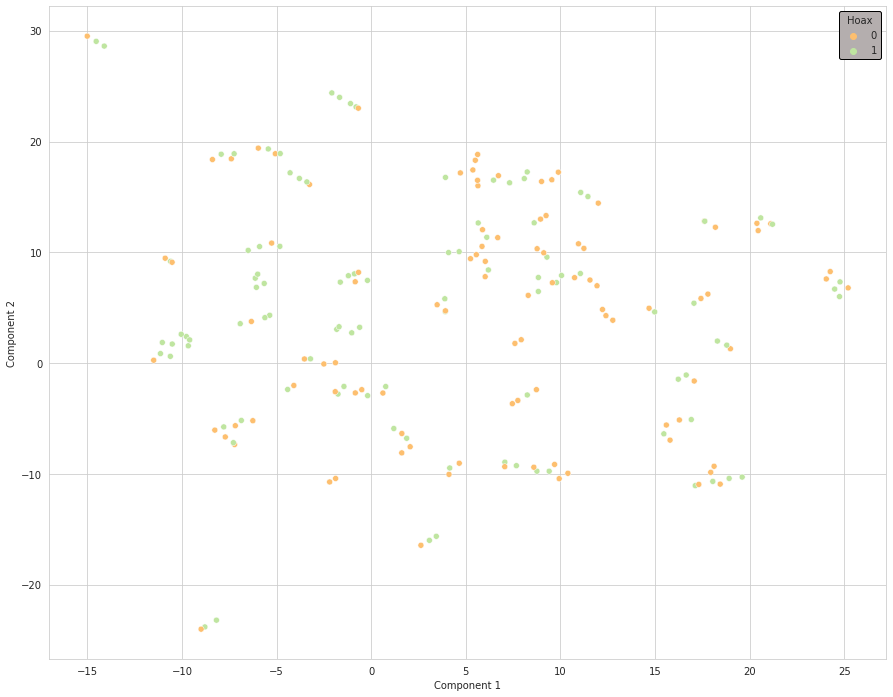

n_neighbors:5, min_dist:0.01


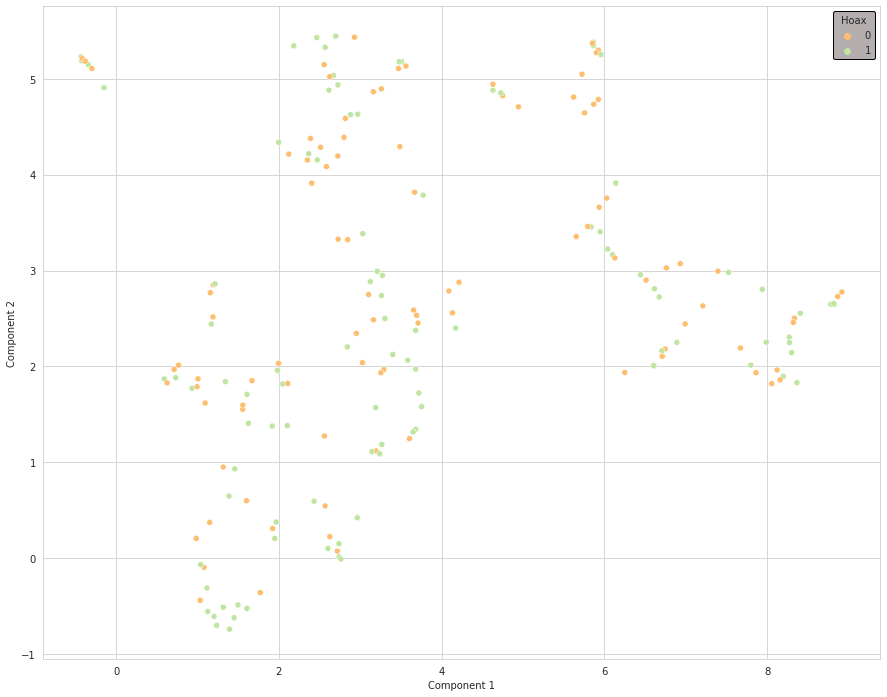

n_neighbors:5, min_dist:0.1


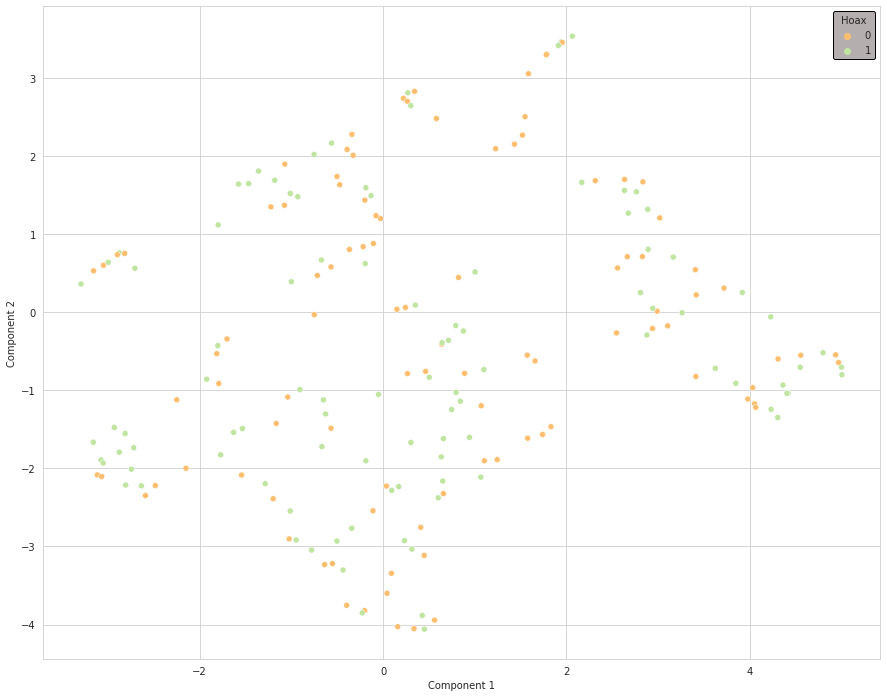

n_neighbors:5, min_dist:0.25


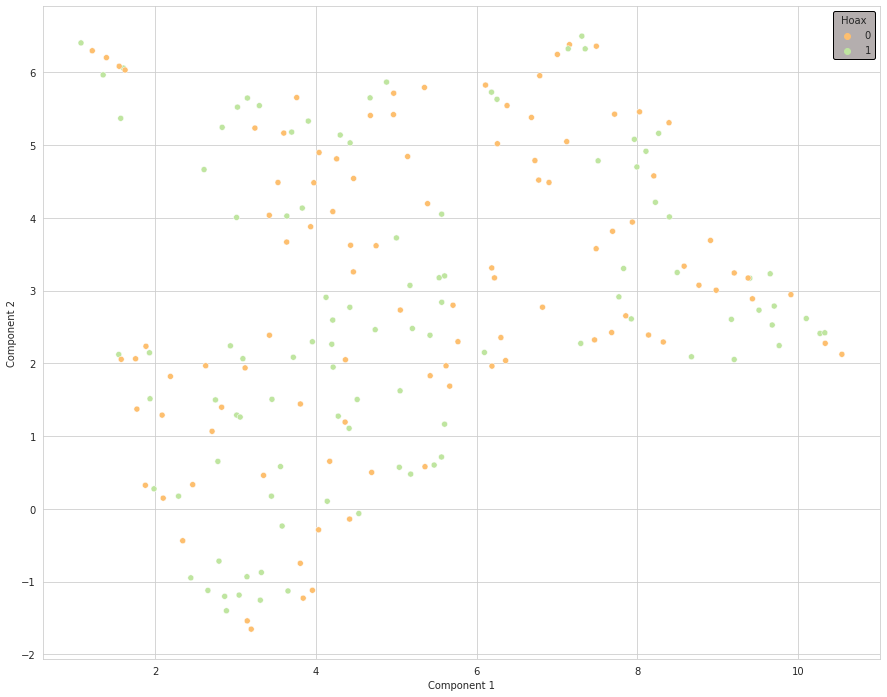

n_neighbors:5, min_dist:0.5


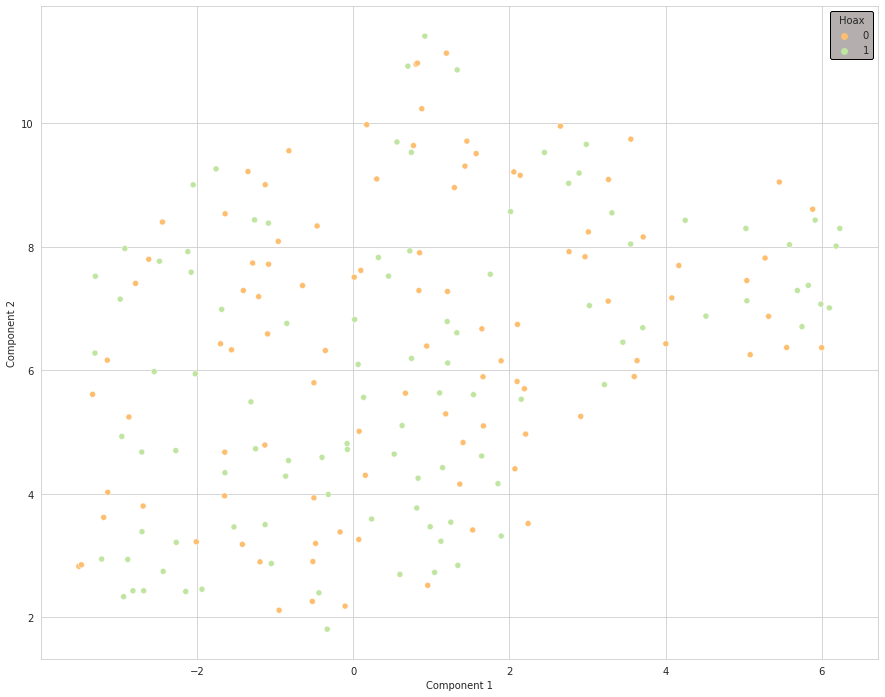

n_neighbors:5, min_dist:0.75


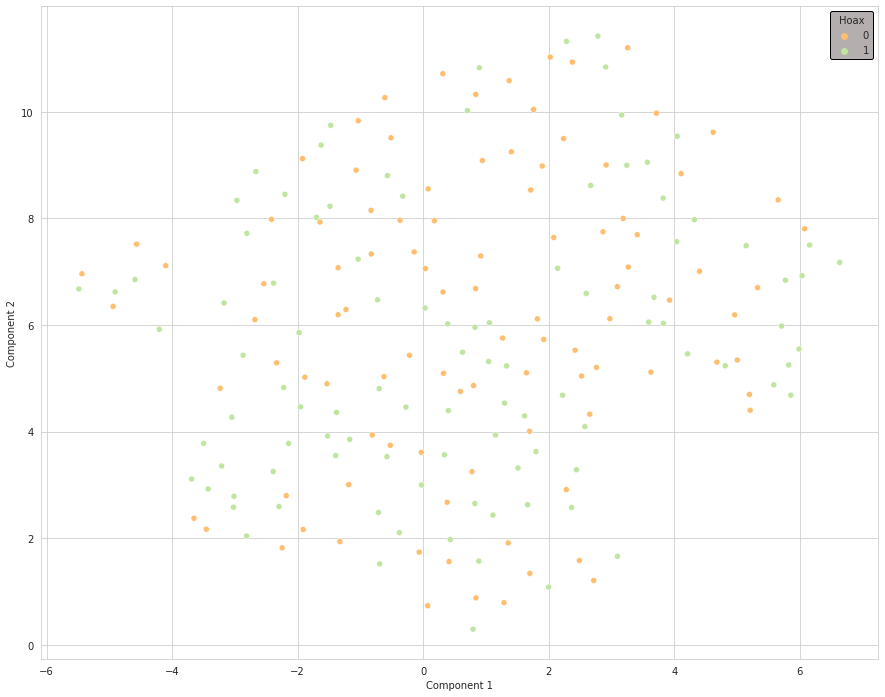

n_neighbors:5, min_dist:0.9


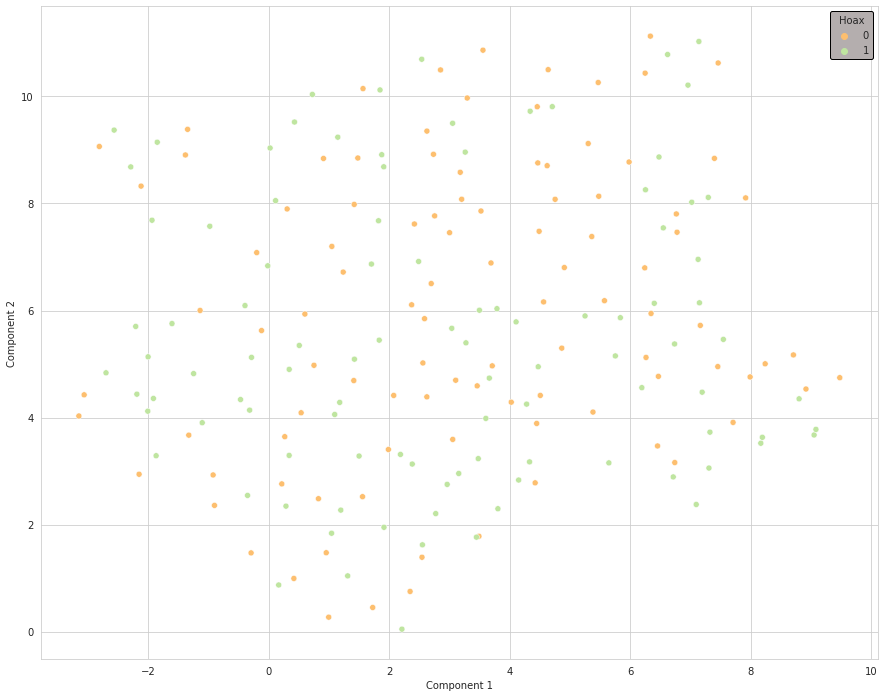

n_neighbors:5, min_dist:0.99


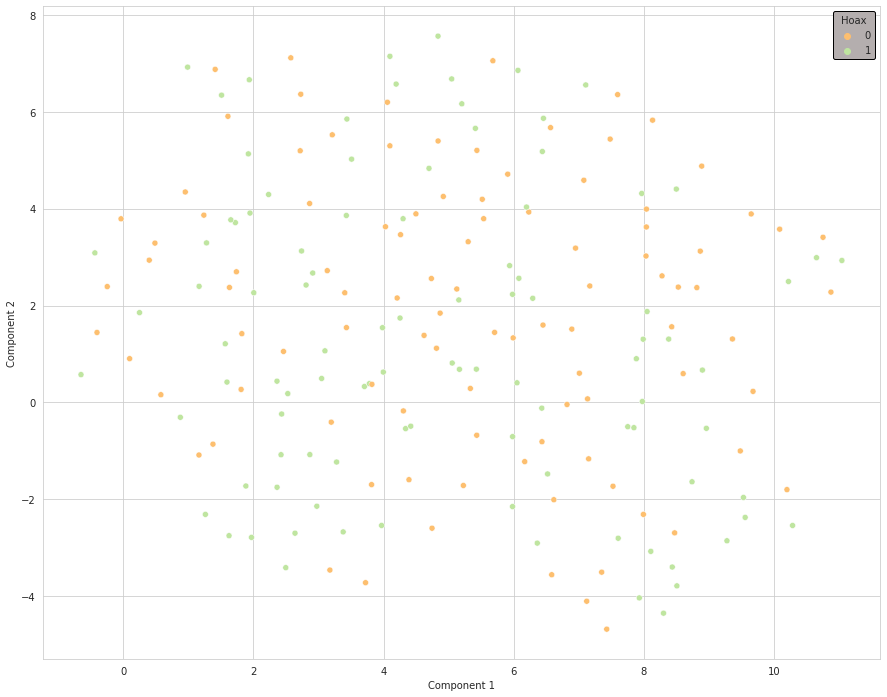

n_neighbors:10, min_dist:0.01


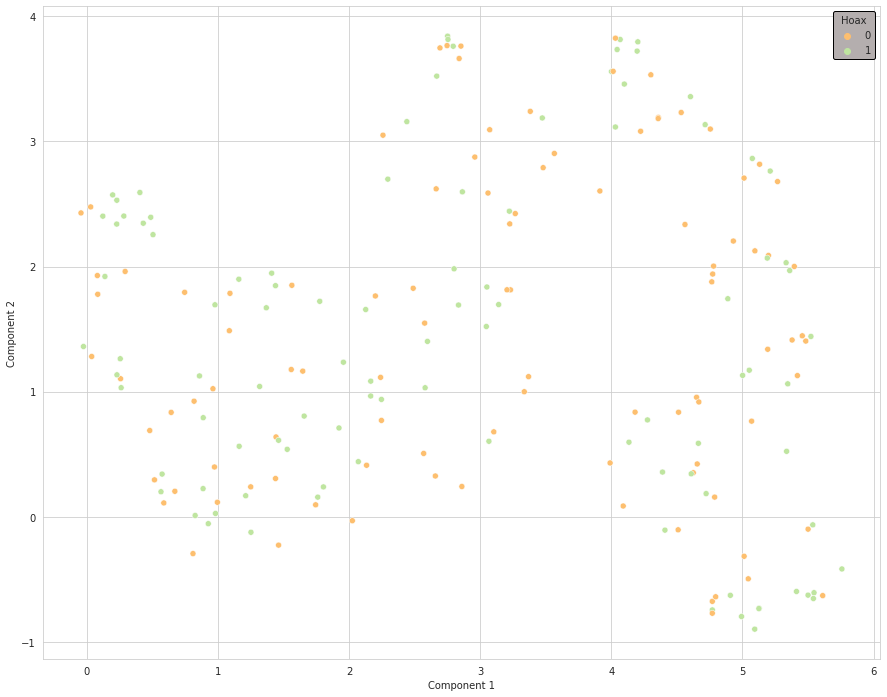

n_neighbors:10, min_dist:0.1


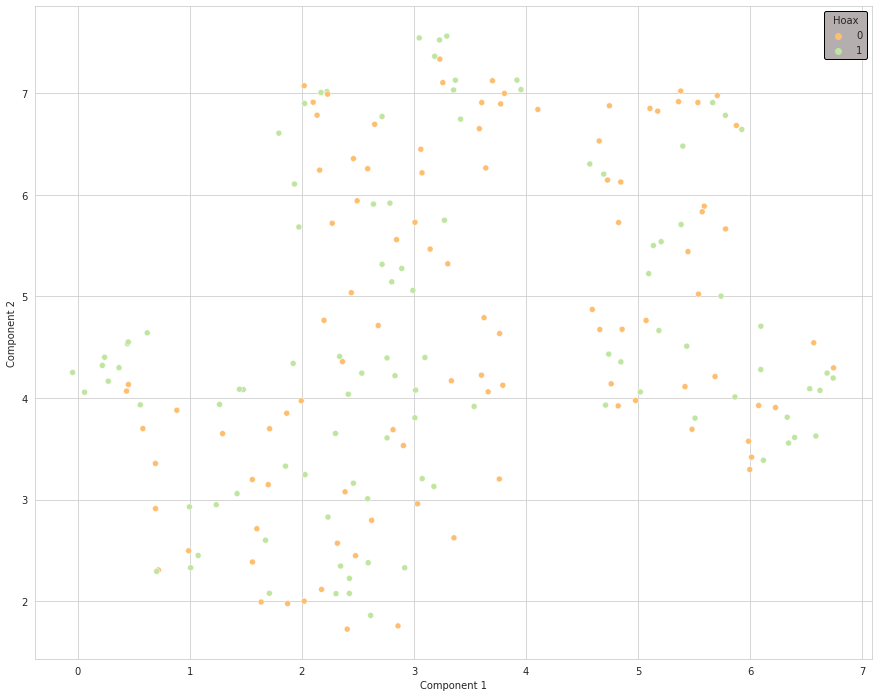

n_neighbors:10, min_dist:0.25


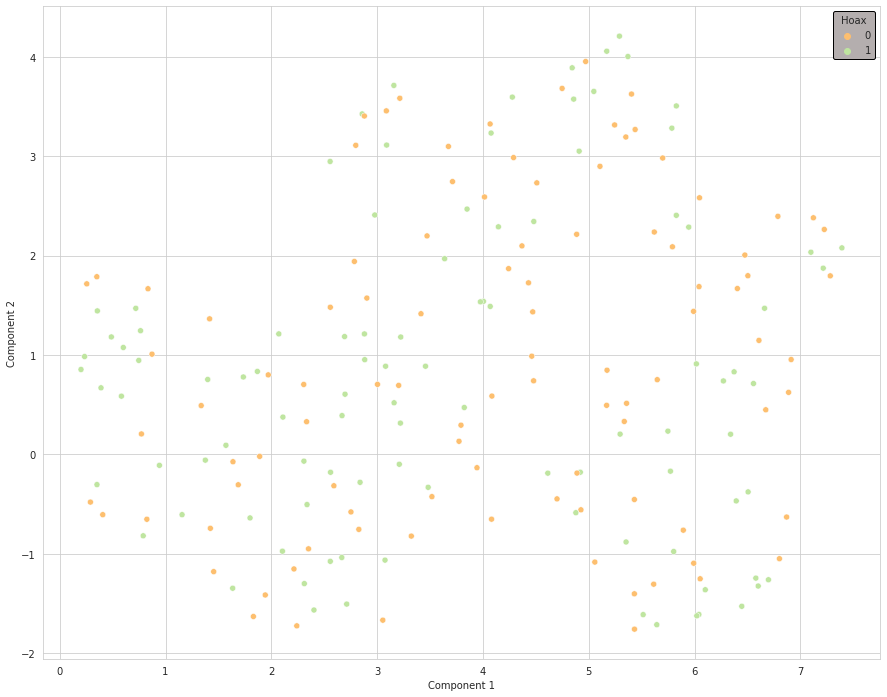

n_neighbors:10, min_dist:0.5


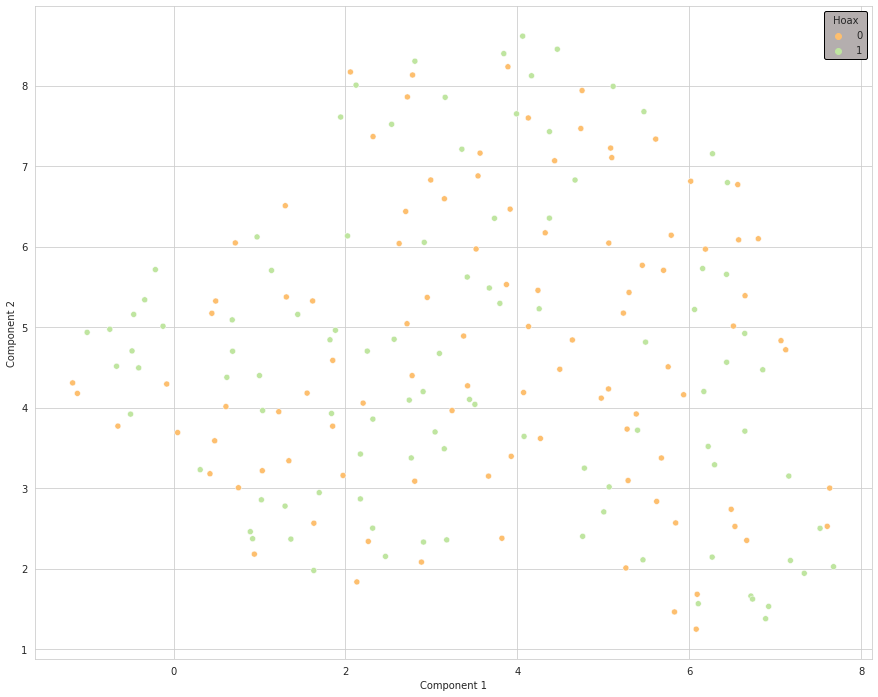

n_neighbors:10, min_dist:0.75


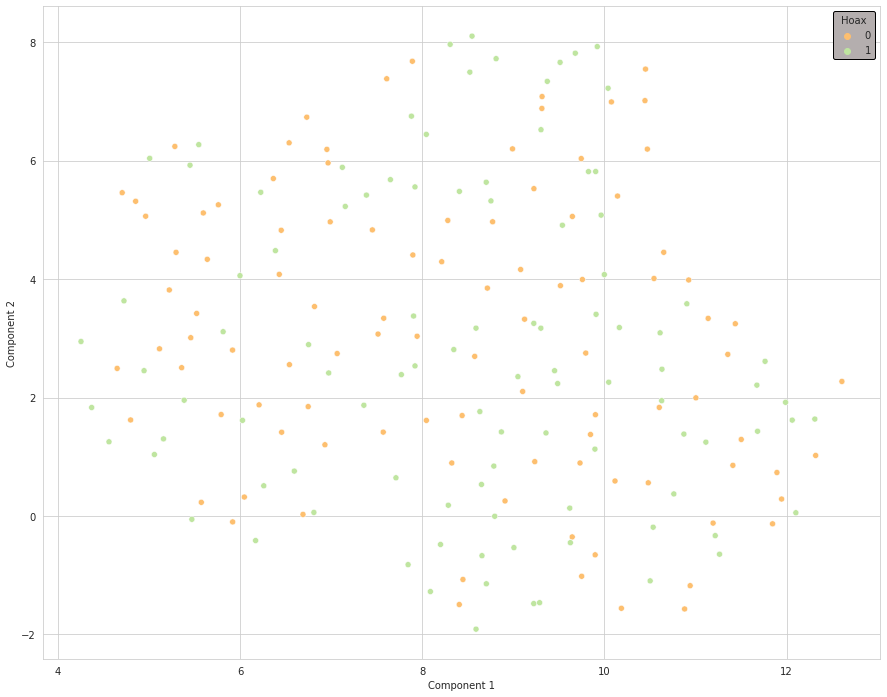

n_neighbors:10, min_dist:0.9


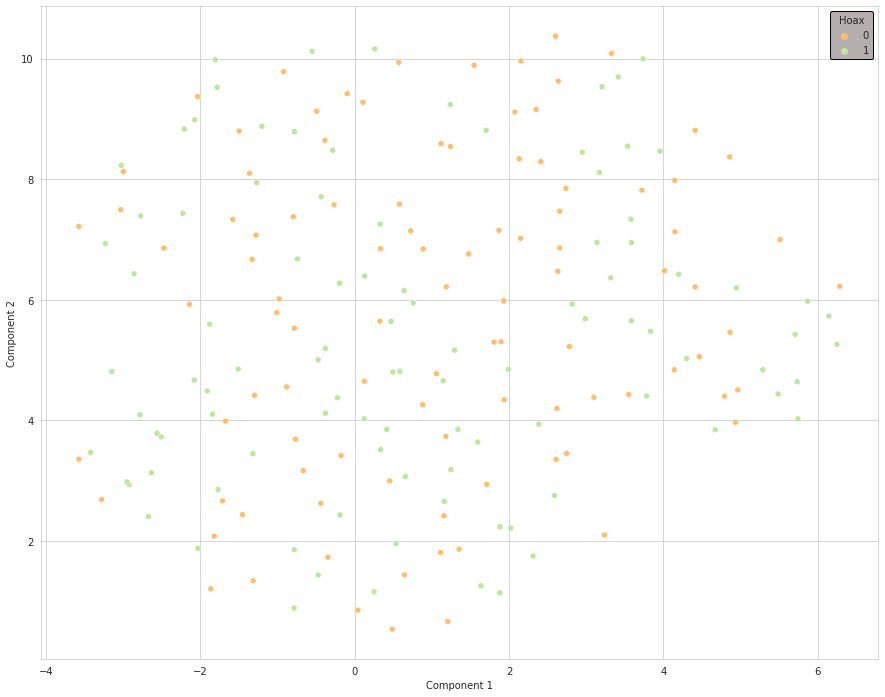

n_neighbors:10, min_dist:0.99


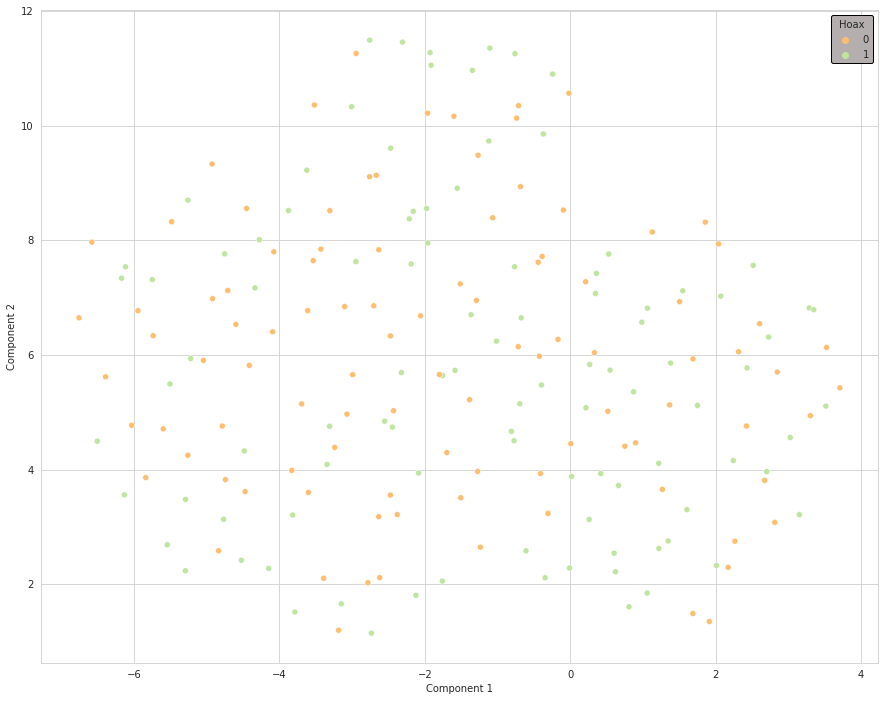

n_neighbors:20, min_dist:0.01


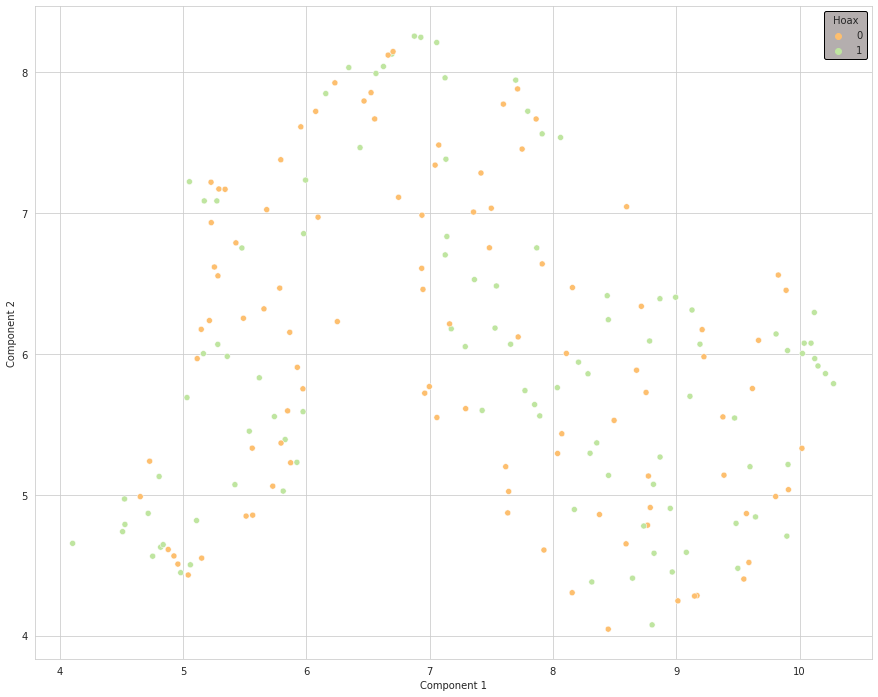

n_neighbors:20, min_dist:0.1


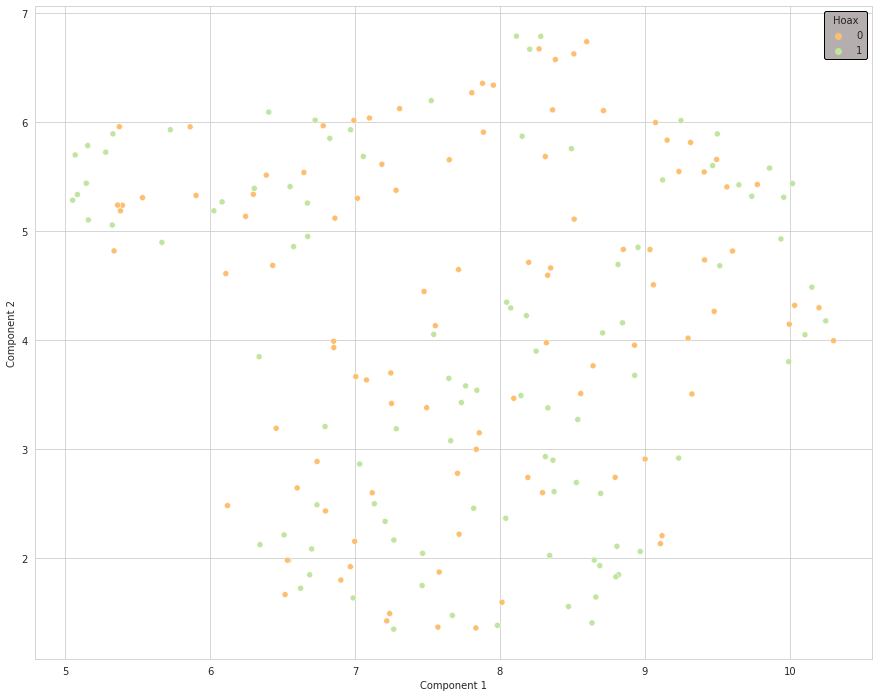

n_neighbors:20, min_dist:0.25


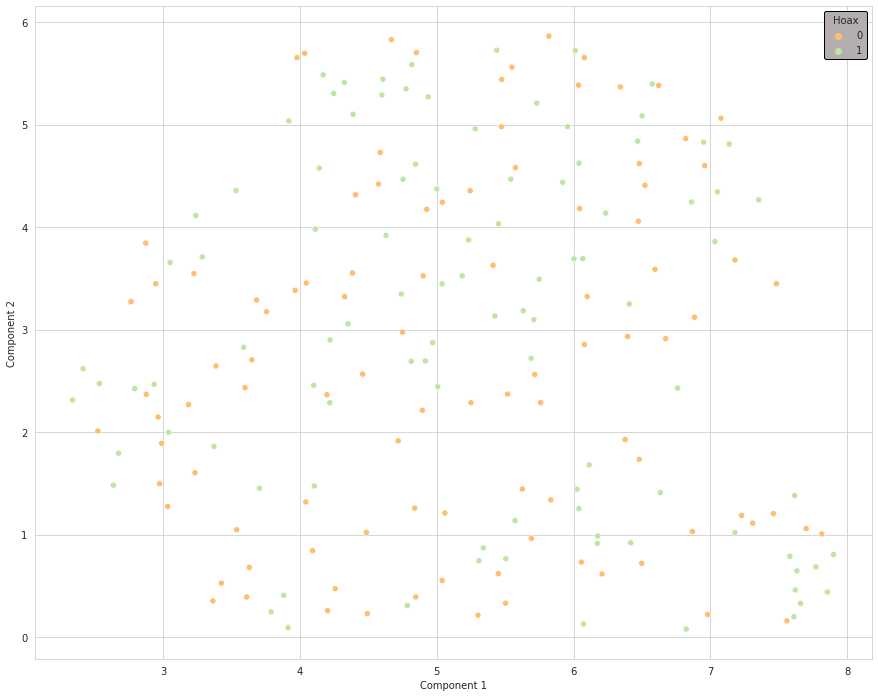

n_neighbors:20, min_dist:0.5


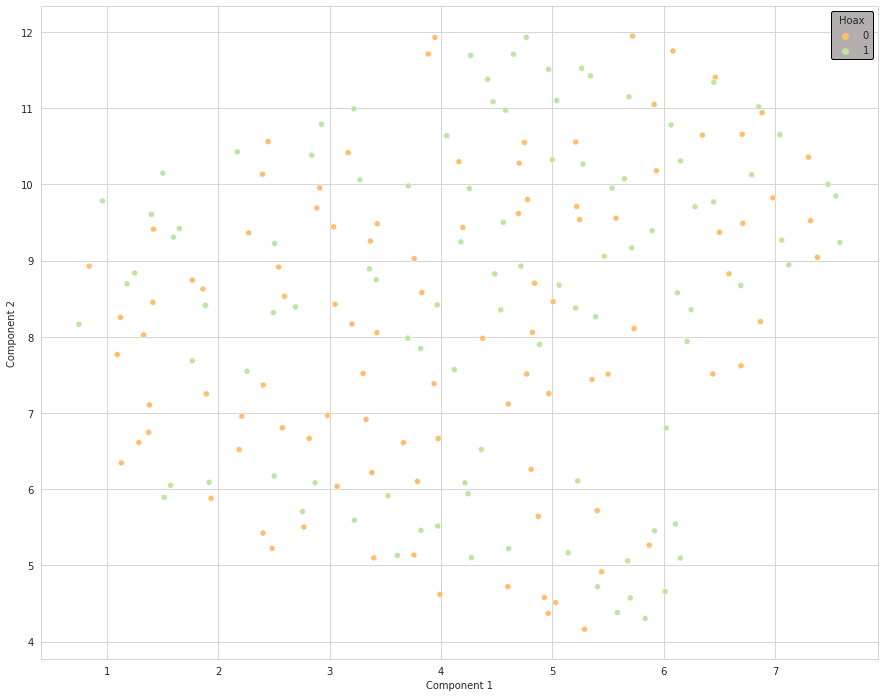

n_neighbors:20, min_dist:0.75


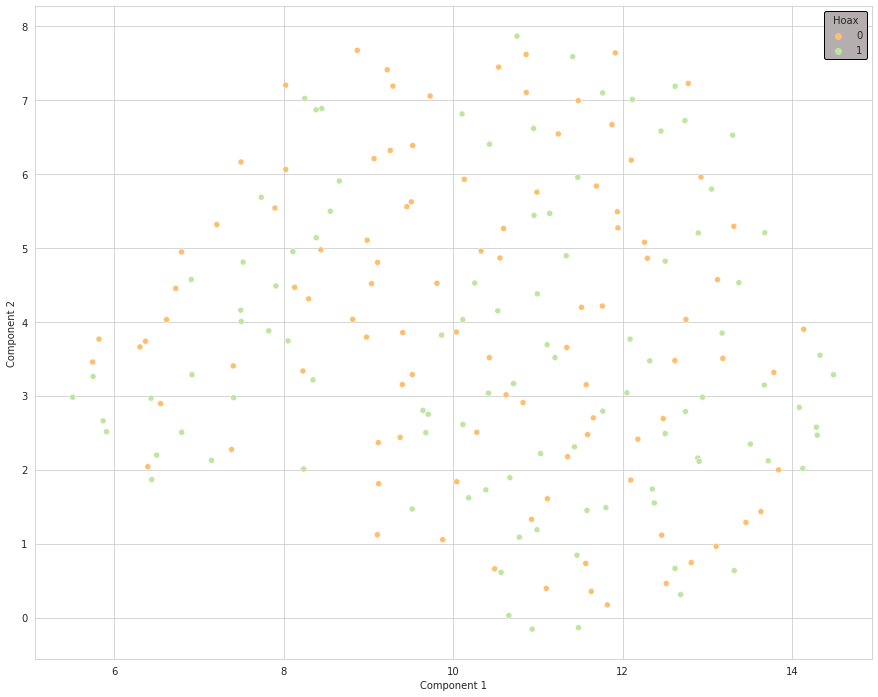

n_neighbors:20, min_dist:0.9


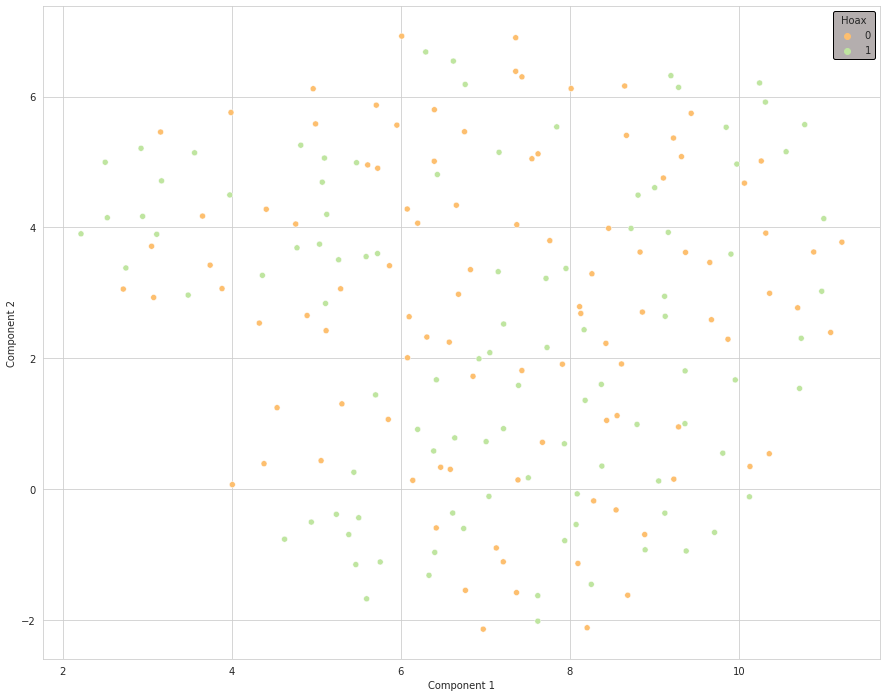

n_neighbors:20, min_dist:0.99


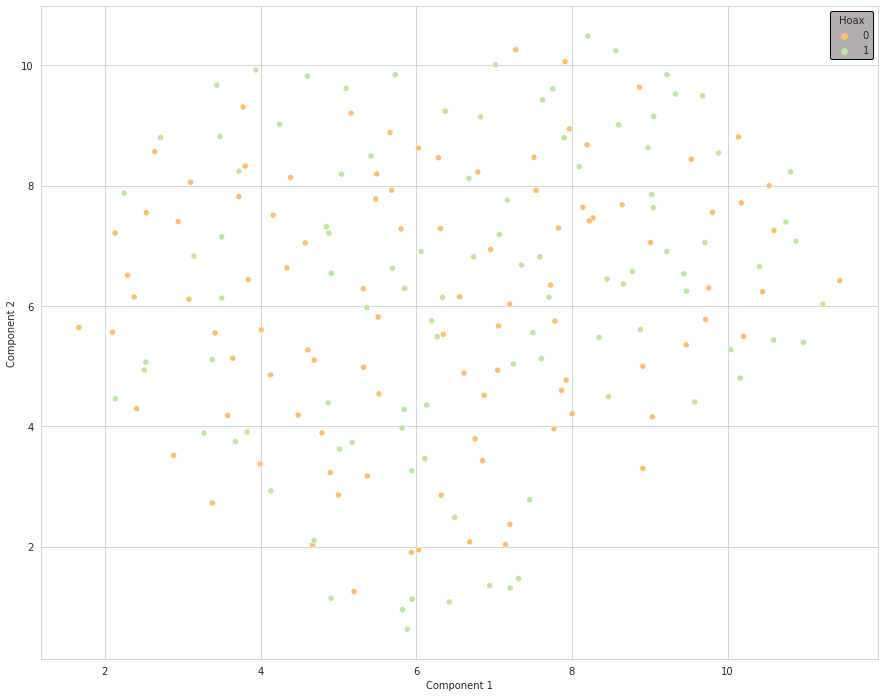

In [ ]:
neighbors = [2, 5, 10, 20, 50, 100]
min_dist = [.01, .1, .25, .5, .75, .9, .99]
params = [{'n_neighbors': nn, 'min_dist': md} for nn in neighbors for md in min_dist]

[make_plot(embeddings_test, **kwparams) for kwparams in params]

In [14]:
x = make_plot(embeddings_test, 5, .01)

n_neighbors:5, min_dist:0.01


In [27]:
x.iloc[10:20]

umap_0    umap_1  label
user_id                                                     
13e60f3210fa7bda9a427787f86cca12  12.750381  8.794642      0
14ea9d9e9ef139af4d95ea95faae4cf3  11.500046  8.039630      0
151eeeb1df123a7cb643c5e37e3b5096  13.606333  7.679985      1
15c60b79cc79e7bea8c69d70d90f4035  13.839576  8.284276      1
175e1df16d9199c091648ebde938fc84  12.831091  8.896047      0
183e5afe26378fc868028a3e64c7e059  12.297661  8.633939      0
18e0dfc8b56b122e88ffd753ca10537   14.296601  8.635938      1
1918c004fdeffa00edcb8b87e17738a1  11.132994  7.475088      0
1a864bebb8e61be6f677323da8e7c51b  14.311511  8.574201      0
1da1c9xs22c5je2inx9tcb5c2j6vwv8c   1.556097  7.036828      0

In [22]:
y = test.groupby('user_id').apply(lambda x: '\n'.join(x.text.tolist()))
y

user_id
034rhbdu5dxg1p7ugwbdvo9oze9680kn    RT #USER#: Trump's legal team gave thousands i...
03qvyd6yvx7sc1ggl0x64h37qqk1ohyw    Kobe Bryant, NBA Superstar dies in copter cras...
08gb34g7782zv14rkom8xd44s31gsvdy    the Power of contemporary Art - International ...
090lrhtfoz1zm7quye676g4ktx597img    Former Wolves manager linked with fierce rival...
0pthhz6l89xsaxqkgneo9mlkixswsqc0    Asylum seekers worry new US policy will mean m...
                                                          ...                        
z98oow5h1kp1vffleg7k1f67s4jv9ibv    #USER# #USER# #USER# #USER# #USER# Thx Moni! E...
z9di4ct4f8vq0zo49f8nf8kcjd921jty    Oscars 2020 Voter Thinks Adam Sandler's 'Arrog...
zapxq6vcsq2m01gjwzhidnk633f4xn1n    Tinashe's Best Selfie Advice Will Get You All ...
zsnv7bpeyd0368gglbryiwwb5snfgt6s    Microsoft Giving Away a Jordan Proto-React Xbo...
zww9s2kf5f9oym6aehodkduzpjkxho7a    #USER# #USER# #USER# #USER# #USER# #USER# #USE...
Length: 400, dtype: object

In [23]:
y.loc['034rhbdu5dxg1p7ugwbdvo9oze9680kn'][:700]

"RT #USER#: Trump's legal team gave thousands in contributions to Republican senators ahead of the impeachment trial, according to da‚Ä¶\nRT #USER#: Classic #USER# let‚Äôs start the super bowl off with pro-war propaganda with former anti-war player/veran Pat Tillman. Dude lite‚Ä¶\nKeep this going to piss Trump offüòÇ #URL#\nRT #USER#: Nixon cost the Republicans 8 Senate and 40 House seats, this is far worse. Nixon's crimes were child's play compared to what T‚Ä¶\nRT #USER#: The fact that Republicans are so incredibly butt hurt by Nancy Pelosi ripping up some paper proves that Dems need to s‚Ä¶\nRT #USER#: President Ford pardoned his predecessor, Nixon, after he resigned amid the Watergate scandal.  ‚ÄúIt could "

In [24]:
y.loc['03qvyd6yvx7sc1ggl0x64h37qqk1ohyw'][:700]

"Kobe Bryant, NBA Superstar dies in copter crash #URL#\nLong Lost Brother Miraculously Found ‚Äòliving In The Bush‚Äô In South Africa! #URL#\nCrescent Varsity Restates Commitment to Academic Plus #URL# #URL#\n2020; A time to learn and deliver the economy\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 #URL# #URL#\nDelta Governor's Aide Put Smiles On Faces Of Primary School Pupils #URL# #URL#\nGov. Tambuwal Leads PDP Governors Forum #URL# #URL#\nFidelity Bank Appoints Isa Inuwa As Independent Non-executivedirector. #URL# #URL#\nForbes 2020 World‚Äôs Richest Rankings Released: Only 4 Nigerians Make Exclusive Billionaires List #URL#\nA law enforcement related commentary on mishandling death #URL# #URL#\nTraders Of The Onitsha Drug Market Must Be All"

In [26]:
y.loc['10ce3ae6fe01b1198fb1da990ff474f4'][:700]

'Nicol√°s Maduro amenaza con lanzar misiles contra Espa√±a: "Vamos a desplegar todo nuestro sistema de misiles" #URL#\nUna muerte en un ambulatorio sin m√©dicos cuestiona los recortes de la sanidad gallega #URL#\nHe publicado un v√≠deo nuevo en Facebook #URL#\nEl nieto de Franco afirma que los decretos son para temas urgentes, no para "tomarse la revancha 42 a√±os despu√©s" #URL#\nEsc√°ndalo en Grecia: 30 miembros de una ONG son detenidos por tr√°fico de humanos #URL#\nEstos s√≥n m√°s Listo que los pol√≠ticos de Espa√±a #URL#\nCojonudo es √©ste t√≠o mirarlo asta el final #URL#\nVOX esta sacando toda la mierda de la Susana D√≠az y todo lo que ten√≠a en el cortijo viva el fontanero\n9 monjas quedan embarazadas en un m'

In [28]:
y.loc['1a864bebb8e61be6f677323da8e7c51b'][:700]

'(Incluye video) Cuando se terminaba el primer tiempo y el equipo comenzaba a generar dudas por la falta de... #URL#\nPubliqu√© una nueva foto en Facebook #URL#\n(Incluye galer√≠a) En medio de los viajes y empezando un mes que los tendr√° √≥cupad√≠simos, los jugadores... #URL#\nTal como lo hizo Barovero, Rojas tambi√©n manifest√≥ que el grupo bancar√° al colombiano en caso de que decida... #URL#\nEn la antesala al partido de Primera entre River y San Lorenzo en el Nuevo Gas√≥metro, el conjunto de Zapata... #URL#\nSin Whatsapp hasta un buen tiempo...ü§¶ü§¶: me siento desactualizado\nPezzella asegur√≥ que, m√°s all√° de su ingreso temporal por Maidana, se considera tan protagonista como cualquier... #URL#\nEl reconoc'